In [9]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sqlalchemy import create_engine
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#plt.rcParams['figure.figsize'] = (20,10)


In [10]:
data_dir = "..\\Dados"
db_file = 'fundos.db'
engine = create_engine("sqlite:///"+os.path.abspath(os.path.join(data_dir, db_file)))

In [11]:
data_inicio = '2005-01-01'
data_fim = '2017-12-31'
cnpj_fundo = '12.055.107/0001-16' #Alaska Black Master BDR 1

### Seleciona Carteira

In [12]:
#cotas
sqlquery = """
select VL_QUOTA, DT_COMPTC from inf_diario
where CNPJ_FUNDO = '{cnpj_fundo}'
and DT_COMPTC >= '{data_inicio}'
and DT_COMPTC <= '{data_fim}'
""".format(cnpj_fundo=cnpj_fundo, data_inicio=data_inicio, data_fim=data_fim)
cotas = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_COMPTC']).set_index("DT_COMPTC")['VL_QUOTA'].sort_index()
data_inicio = cotas.index.min().strftime("%Y-%m-%d")

In [13]:
#carteira e pesos
sqlquery = """
select * from cda
where CNPJ_FUNDO = '{cnpj_fundo}'
and DT_COMPTC >= '{data_inicio}'
and DT_COMPTC <= '{data_fim}'
""".format(cnpj_fundo=cnpj_fundo, data_inicio=data_inicio, data_fim=data_fim)
carteira = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_COMPTC'])
pl = carteira.sort_values(['DT_COMPTC', 'FILE'])['VL_PATRIM_LIQ'].fillna(method='bfill')
carteira['VL_PATRIM_LIQ'] = pl
carteira['peso'] = carteira['VL_MERC_POS_FINAL'].div(carteira['VL_PATRIM_LIQ'])

#COD ISIN, COD B3, Ações bloco 8, opções bloco 8
pivot_cols = carteira.CD_ATIVO\
            .fillna(carteira.CD_ISIN)\
            .fillna(carteira.CD_ATIVO_BV_MERC)\
            .fillna(carteira[carteira.FILE.str.contains('BLC_8') & carteira.TP_ATIVO.str.contains("Ação|Opção")].DS_ATIVO.str.extract(r'([A-Z]+\d+)', expand=False))\
            .fillna(carteira[carteira.FILE.str.contains('BLC_8')].DS_ATIVO.str.extract(r'(BR[A-Z0-9]+)', expand=False))\
            #.fillna(carteira[carteira.FILE.str.contains('BLC_8')].DS_ATIVO.str.extract(r'(DI1[A-Z0-9]+)', expand=False))\
            #.fillna(carteira[carteira.FILE.str.contains('BLC_8')].DS_ATIVO.str.extract(r'(DOL[A-Z0-9]+)', expand=False))\
            #.fillna(carteira[carteira.TP_ATIVO.str.contains("Ação").fillna(False)].DS_ATIVO.str.extract(r'([A-Z]+\d+)', expand=False))\
            #.fillna(carteira[carteira.TP_ATIVO.str.contains("Opção").fillna(False)].DS_ATIVO.str.extract(r'([A-Z]+\d+)', expand=False))\
            
            #.fillna(carteira.DS_ATIVO.str.extract(r'(^DI1[A-Z]{2}\d{2})', expand=False))\
            #.fillna(carteira.DS_ATIVO.str.extract(r'(^DOL.+)', expand=False))\
            #.fillna(carteira.CD_INDEXADOR_POSFX)
pesos = carteira.pivot_table(index='DT_COMPTC', columns=pivot_cols, values='peso')

In [14]:
### Ativos
### ABRE11 == SEDU3
sqlquery = """
select * from cotacoes
WHERE CODNEG in ('{ativos}')
and DATA >= '{data_inicio}'
and DATA <= '{data_fim}'
""".format(ativos="','".join(pesos.columns), data_inicio=data_inicio, data_fim=data_fim)
retornos_acoes = pd.read_sql_query(sqlquery, engine, parse_dates=['DATA']).pivot_table(index='DATA', columns='CODNEG', values='PREULT').div(100).pct_change()

### Titulos
sqlquery = """
select * from titulos_publicos
WHERE CODISI in ('{ativos}')
and DT_MOV >= '{data_inicio}'
and DT_MOV <= '{data_fim}'
""".format(ativos="','".join(pesos.columns), data_inicio=data_inicio, data_fim=data_fim)
retornos_titulos = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_MOV']).pivot_table(index='DT_MOV', columns='CODISI', values='VALOR_PAR').pct_change()

In [15]:
vencimentos_futuros = list("FGHJKMNQUVXZ")
slc = lambda s,e :slice(vencimentos_futuros.index(s),vencimentos_futuros.index(e)+1)
futuros_carteira = []
for c in pesos.columns:
    m = re.match(r"(DI1|DOL)(\w)(\w)(\d+)", c)
    if m:
        atv, s, e, ano = m.groups()
        for a in vencimentos_futuros[slc(s,e)]:
            futuros_carteira.append((atv+a+ano, c))

In [17]:
### Futuros
#sqlquery = """
#select DATE as DT_MOV, substr(MERCADORIA,0,4) || VENCIMENTO as CODIGO, PRECO_ATUAL/PRECO_ANTERIOR - 1 as PCT_CHANGE, VARIACAO from futuros
#WHERE CODIGO in ('{ativos}')
#and DT_MOV >= '{data_inicio}'
#and DT_MOV <= '{data_fim}'
#""".format(ativos="','".join(set([v[0] for v in futuros_carteira])), data_inicio=data_inicio, data_fim=data_fim)
#retorno_futuros = pd.read_sql_query(sqlquery, engine, parse_dates=['DT_MOV']).pivot_table(index='DT_MOV', columns='CODIGO', values='PCT_CHANGE').groupby(dict(futuros_carteira), axis=1).mean()

In [172]:
#retornos = pd.concat([retornos_acoes,retornos_titulos, retorno_futuros], sort=False, axis=1).dropna(how='all').fillna(method='bfill')
retornos = pd.concat([retornos_acoes,retornos_titulos], sort=False, axis=1)
#retornos = retornos_acoes

# Kalman

In [295]:
eom_pesos = pesos.resample('D').bfill().reindex(index=cotas.index).reindex(index=cotas.groupby(pd.Grouper(freq='M')).tail(1).index)
states = eom_pesos.reindex(columns=retornos.columns, index=cotas.index)
signals = retornos.reindex(index=cotas.index).fillna(method='pad')#.rolling(5).median()
measurements = ((cotas - cotas.shift())/cotas).fillna(0)

n_dim = len(states.columns)

from filterpy.kalman import KalmanFilter
from filterpy.common import Saver, inv_diagonal
import tqdm
import time

kf = KalmanFilter(n_dim,1+ n_dim)
#kf.inv = np.linalg.pinv
kf.F *= 1
kf.P = np.diag([1]*n_dim)
kf.Q *= 0.25
#kf.R *= 0.01
#kf.x = pesos.iloc[0].fillna(0).values

s = Saver(kf)
state_mask = np.zeros(n_dim)
dtx = None
for i,dt in tqdm.tqdm_notebook(enumerate(measurements.index), total=len(cotas)):
    #time.sleep(1e-3)
    if dt in eom_pesos.index:
        state_mask = states.replace(0,np.nan).fillna(method='bfill', limit=1)
        state_mask = state_mask.isnull().mul(1).loc[dt].values
        kf.H = np.vstack([signals.loc[dt].fillna(0).values.reshape(1,n_dim), np.eye(n_dim)])
        kf.R = np.eye(kf.dim_z)*1e-2
    else:
        kf.H = np.vstack([signals.loc[dt].fillna(0).values.reshape(1,n_dim), np.diag(state_mask)]).astype(float)
        kf.R = np.diag(np.hstack([np.array(1e-2), (state_mask * 1e-1) + 1e-3])).astype(float)
        
    kf.predict()
    kf.update(np.hstack([measurements.loc[dt], states.loc[dt].fillna(0)]))
    #st[dt] = pd.Series(kf.x[:,0])
    s.save()

s.to_array()
#st = pd.concat(st,1)
#st.index = states.columns
#ax = pd.DataFrame(s.x[:,:,0], index=p2.index).plot(figsize=(20,10))
#p1[['a','b']].plot(ax=ax, linestyle=':')
#pd.Series(0.1, )a

In [296]:
from filterpy.kalman import rts_smoother
sx, sP, sK, spP = rts_smoother(s.x, s.P, s.F, s.Q)
smooth = pd.DataFrame(sx[:,:,0], index=measurements.index, columns=signals.columns)

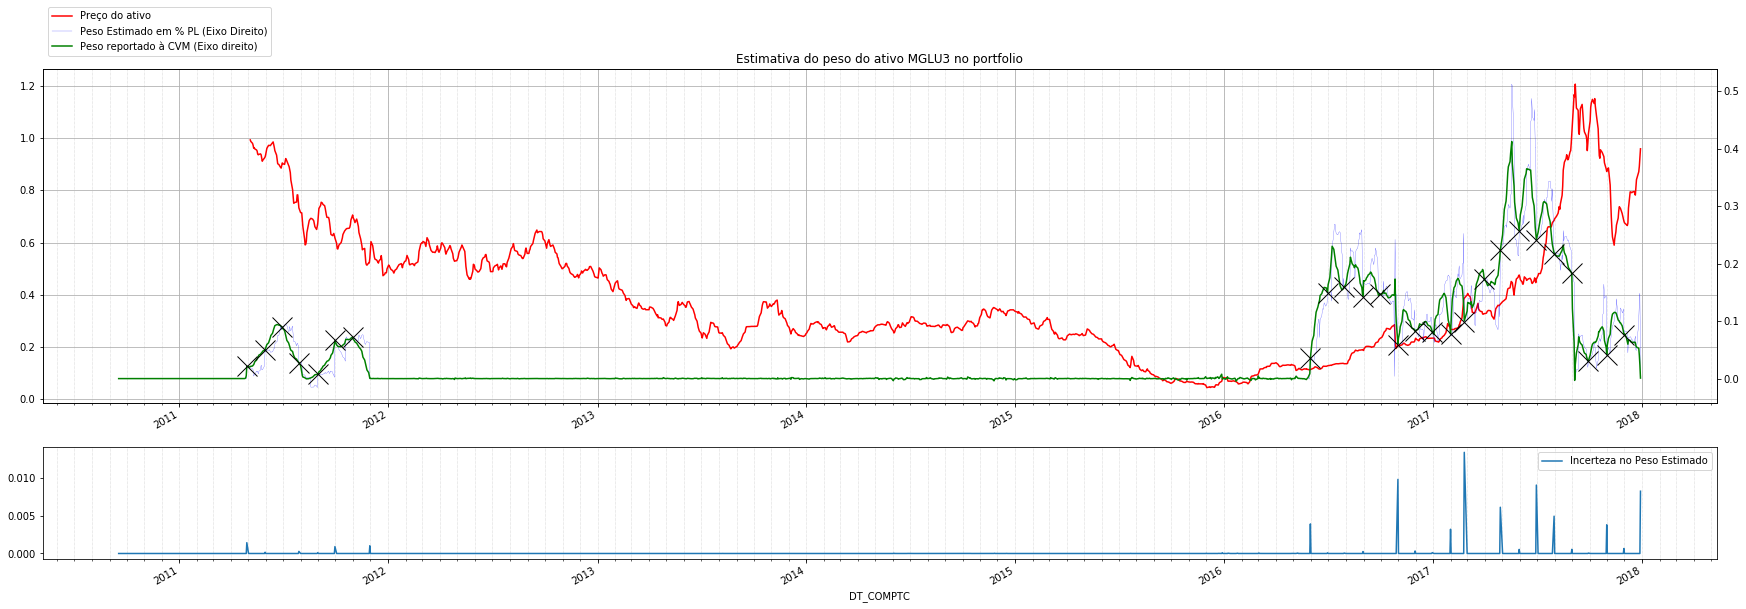

In [301]:
#verifica o ativo 
%matplotlib inline

ativo = 'MGLU3'#'ABCB4'

estimativas = pd.DataFrame(s.x[:,:,0], index=measurements.index, columns=signals.columns)
erro_estimativa_ativo = pd.Series(s.y[:,estimativas.columns.get_loc(ativo) +1 ,0], index=measurements.index).pow(2).div(s.S[:,estimativas.columns.get_loc(ativo) + 1,estimativas.columns.get_loc(ativo) + 1])


fig, ax = plt.subplots(2,1, figsize=(30,10), sharex=False, gridspec_kw=dict(height_ratios=[3,1], hspace=0.2), facecolor='white')
#ax = [ax]
estimativas.loc[:,ativo].plot(secondary_y=True, color='Blue', legend='peso', ax=ax[0], lw=.2)
smooth.loc[:,ativo].plot(secondary_y=True, color='Green', legend='peso', ax=ax[0])
states[ativo].dropna().plot(marker='x', linestyle='', color='black', markersize='20', secondary_y=True, ax=ax[0])
signals.loc[:,ativo].rolling(3).median().add(1).cumprod().plot(color='red',ax=ax[0])



import matplotlib.dates as mdates

ax[0].xaxis.set_minor_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_locator(mdates.YearLocator())
ax[0].grid(which='major', linestyle='-')
ax[0].grid(which='minor', linestyle=':', lw=.5)

ax[1].xaxis.set_minor_locator( mdates.MonthLocator())
ax[1].xaxis.set_major_locator(mdates.YearLocator())
ax[1].grid(which='major', linestyle='-')
ax[1].grid(which='minor', linestyle=':', lw=.5)


erro_estimativa_ativo.plot(ax=ax[1])

[t.set_visible(True) for t in ax[0].get_xticklabels()]
ax[0].set_title("Estimativa do peso do ativo {} no portfolio".format(ativo))
handlers = ax[0].get_legend_handles_labels()[0] + ax[0].right_ax.get_legend_handles_labels()[0]
ax[0].legend(handlers, ["Preço do ativo", "Peso Estimado em % PL (Eixo Direito)","Peso reportado à CVM (Eixo direito)"], loc=2, bbox_to_anchor=(0,1.2))
ax[1].legend(ax[1].get_legend_handles_labels()[0], ["Incerteza no Peso Estimado"])


Correlacao 0.9847637076563149


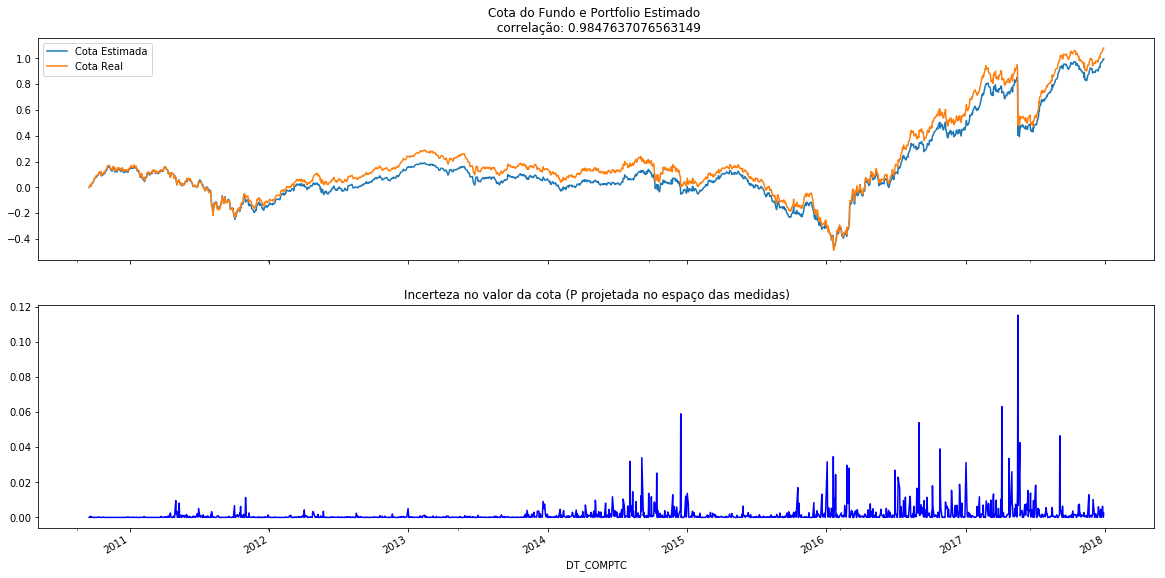

In [298]:
erros = pd.Series(s.y[:,0,0], index=measurements.index).pow(2).div(s.S[:,0,0])

fig, (axu, axd) = plt.subplots(nrows=2, ncols=1, figsize=(20,10), sharex=True, facecolor='white')
estimativas.mul(signals).sum(1).cumsum().plot(ax=axu)
measurements.cumsum().plot(ax=axu)
erros.plot(color='Blue', secondary_y=False, ax=axd)
print("Correlacao", estimativas.mul(signals).sum(1).corr(measurements))
axu.set_title("Cota do Fundo e Portfolio Estimado \n correlação: {}".format(estimativas.mul(signals).sum(1).corr(measurements)))
axd.set_title("Incerteza no valor da cota (P projetada no espaço das medidas)")
axu.legend(['Cota Estimada','Cota Real'])

In [ ]:
pd.Series(s.y[:,0,0]).plot(color='red', figsize=(20,10))
pd.Series(s.z[:,0,0]).cumsum().plot(color='blue')
cotas.reset_index(drop=True).sub(1).plot()

In [ ]:
plt.stackplot(estimativas.index, estimativas.values.T, baseline='weighted_wiggle', colors=sns.color_palette("coolwarm", len(estimativas.columns)))
plt.gcf().set_size_inches(20,10)

In [ ]:
estimativas.pow(2).pow(0.5).plot.area(stacked=True, figsize=(20,10), legend=None, cmap='coolwarm')

In [ ]:
signals.loc['2011-05-01':'2011-06-30'].reindex(columns=a.columns).add(1).cumprod().plot(figsize=(20,10), legend=False)
signals.loc['2011-05-01':'2011-06-30'].reindex(columns=a.columns).add(1).cumprod()['ABCB4'].plot(lw=5, color='black')

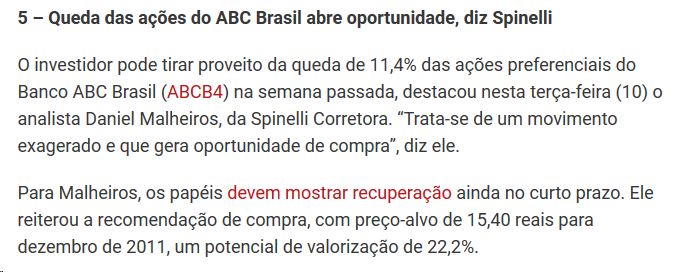

g)